In [2]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

In [3]:
# Define the paths
data_dir = 'data/raw'
output_dir = 'data/processed'

# Define the class names for the dataset
class_names = [
    "High squamous intra-epithelial lesion",
    "Low squamous intra-epithelial lesion",
    "Negative for Intraepithelial malignancy",
    "Squamous cell carcinoma"
]

In [4]:
# Function to get the list of image file paths and their associated labels
def get_image_paths_and_labels(data_dir, class_names):
    image_paths = []
    labels = []

    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        # Get all .jpg images in the class directory
        images = glob.glob(os.path.join(class_dir, '*.jpg'))
        
        # Add image paths and labels to the lists
        image_paths.extend(images)
        labels.extend([idx] * len(images))  # Label is the index of the class

    return image_paths, labels

# Get all image paths and their labels
image_paths, labels = get_image_paths_and_labels(data_dir, class_names)

In [5]:
# Perform the 50-50 split: primary dataset (50%), secondary dataset (50%)
X_primary, X_secondary, y_primary, y_secondary = train_test_split(image_paths, labels, test_size=0.5, stratify=labels)

# Further split the primary dataset into 1/10th for validation and 9/10th for RL training
X_train_rl, X_val_rl, y_train_rl, y_val_rl = train_test_split(X_primary, y_primary, test_size=0.1, stratify=y_primary)

# Further split the secondary dataset into 80-20 for fine-tuning (train-validation split)
X_train_ft, X_val_ft, y_train_ft, y_val_ft = train_test_split(X_secondary, y_secondary, test_size=0.2, stratify=y_secondary)

# Function to copy the images and labels into the new directory
def copy_images_to_new_dir(image_paths, labels, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    for image_path, label in zip(image_paths, labels):
        # Create the target class directory if it doesn't exist
        class_name = class_names[label]
        class_dir = os.path.join(target_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        
        # Copy the image to the appropriate class directory
        shutil.copy(image_path, class_dir)

# Copy the 9/10th images (RL phase training set) and 1/10th validation set
copy_images_to_new_dir(X_train_rl, y_train_rl, os.path.join(output_dir, 'RL_phase/train'))
copy_images_to_new_dir(X_val_rl, y_val_rl, os.path.join(output_dir, 'RL_phase/validation'))

# Copy the secondary dataset (fine-tuning dataset) with 80-20 train-validation split
copy_images_to_new_dir(X_train_ft, y_train_ft, os.path.join(output_dir, 'fine_tuning/train'))
copy_images_to_new_dir(X_val_ft, y_val_ft, os.path.join(output_dir, 'fine_tuning/validation'))

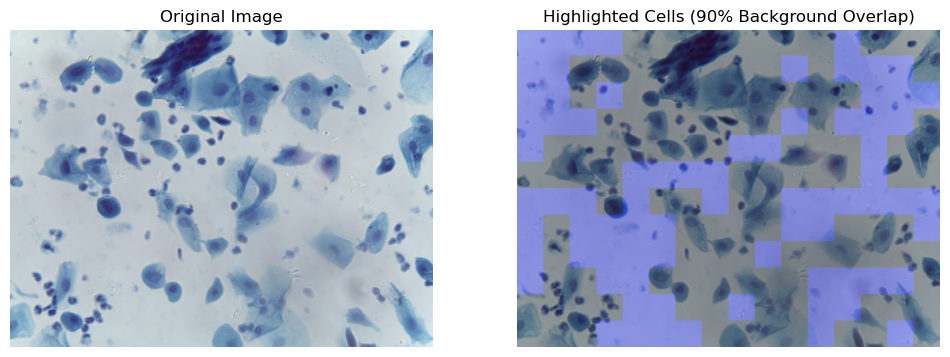

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = './data/processed/RL_phase/train/High squamous intra-epithelial lesion/HSIL_1 (5).jpg'  # Replace with actual image path
image = cv2.imread(image_path)

# Get the image dimensions
height, width, _ = image.shape

# Set the grid cell size to 128x128 pixels
cell_size = 128

# Calculate the number of cells along each axis (16x12 grid)
grid_rows = height // cell_size
grid_cols = width // cell_size

# Convert the image to a 2D array of pixels
image_reshaped = image.reshape((-1, 3))

# Convert to float32 for K-means
image_reshaped = np.float32(image_reshaped)

# Apply K-means clustering to segment the image
k = 2  # We want 2 clusters (foreground and background)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(image_reshaped, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to uint8
centers = np.uint8(centers)

# Identify the background cluster (whitest pixel value)
background_label = np.argmax(centers.sum(axis=1))  # Cluster with the highest sum (whitest cluster)

# Reshape the labels to match the image dimensions
labels_image = labels.reshape(image.shape[:2])

# Create a mask for highlighted grid cells
highlighted_cells = np.zeros_like(image)

# Loop over the 16x12 grid and highlight cells with >90% overlap with background
for i in range(grid_rows):
    for j in range(grid_cols):
        # Define the region of the current grid cell
        y_start, y_end = i * cell_size, (i + 1) * cell_size
        x_start, x_end = j * cell_size, (j + 1) * cell_size
        
        # Extract the grid cell and calculate the background overlap
        cell = labels_image[y_start:y_end, x_start:x_end]
        background_overlap = np.sum(cell == background_label) / cell.size
        
        # If the overlap is greater than 90%, highlight the cell
        if background_overlap > 0.9:
            highlighted_cells[y_start:y_end, x_start:x_end] = [255, 0, 0]  # Highlight in red (RGB)
        
# Visualize the original image and the grid with highlights
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Highlighted Grid Image
highlighted_image = cv2.addWeighted(image, 0.7, highlighted_cells, 0.3, 0)
plt.subplot(1, 2, 2)
plt.title("Highlighted Cells (90% Background Overlap)")
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()
